# Train different Neural Networks on a Traffic Sign Detection Dataset
https://cs231n.github.io/neural-networks-3/#sanitycheck\
https://www.analyticsvidhya.com/blog/2021/12/traffic-signs-recognition-using-cnn-and-keras-in-python/#h-cnn-model-building\
https://medium.com/towards-data-science/8-simple-techniques-to-prevent-overfitting-4d443da2ef7d\
https://www.youtube.com/watch?v=r0RspiLG260\

In [1]:
# global imports
import matplotlib
import matplotlib.pyplot as plt
import os
import random
import numpy as np
from PIL import Image
import cv2

### Data Loading

In [ ]:
import glob

dataset_path = 'data/GTSRB'
classes_path = os.path.join(dataset_path, 'classes.txt')
classes_german_path = os.path.join(dataset_path, 'classes-german.txt', encoding='utf-8')
img_size = 32

with open(classes_path, 'r') as file:
    classes = [line.strip() for line in file.readlines()]

with open(classes_german_path, 'r') as file:
    classes_german = [line.strip() for line in file.readlines()]

images_path = os.path.join(dataset_path, 'Training')
class_folders = [folder for folder in os.listdir(images_path) if os.path.isdir(os.path.join(images_path, folder))]
data = []

for i, folder in enumerate(class_folders):
    folder_path = os.path.join(images_path, folder)
    files = glob.glob(os.path.join(folder_path, '*.ppm'))
    label = int(folder)

    for file in files:
        image = plt.imread(file)
        image = cv2.resize(image, (img_size, img_size))
        data.append((image, label))

print()
print(f'Loaded {len(data)} images')

print('Category distribution:')
for i, class_name in enumerate(classes):
    print(f'{class_name}: {len(list(filter(lambda entry: entry[1] == i, data)))}')



Loaded 26640 images
Category distribution:
Speed limit (20km/h): 150
Speed limit (30km/h): 1500
Speed limit (50km/h): 1500
Speed limit (60km/h): 960
Speed limit (70km/h): 1320
Speed limit (80km/h): 1260
End of speed limit (80km/h): 300
Speed limit (100km/h): 960
Speed limit (120km/h): 960
No passing: 990
No passing for vechiles over 3.5 metric tons: 1350
Right-of-way at the next intersection: 900
Priority road: 1410
Yield: 1440
Stop: 540
No vehicles: 420
Vechiles over 3.5 metric tons prohibited: 300
No entry: 750
General caution: 810
Dangerous curve to the left: 150
Dangerous curve to the right: 240
Double curve: 240
Bumpy road: 270
Slippery road: 360
Road narrows on the right: 180
Road work: 1020
Traffic signals: 420
Pedestrians: 180
Children crossing: 360
Bicycles crossing: 180
Beware of ice/snow: 300
Wild animals crossing: 540
End of all speed and passing limits: 180
Turn right ahead: 480
Turn left ahead: 300
Ahead only: 810
Go straight or right: 270
Go straight or left: 150
Keep r

### Data Visualization
Show random images from loaded data

Displaying 6 random images from each of the following categories: Stop, Priority road, Slippery road, Go straight or right


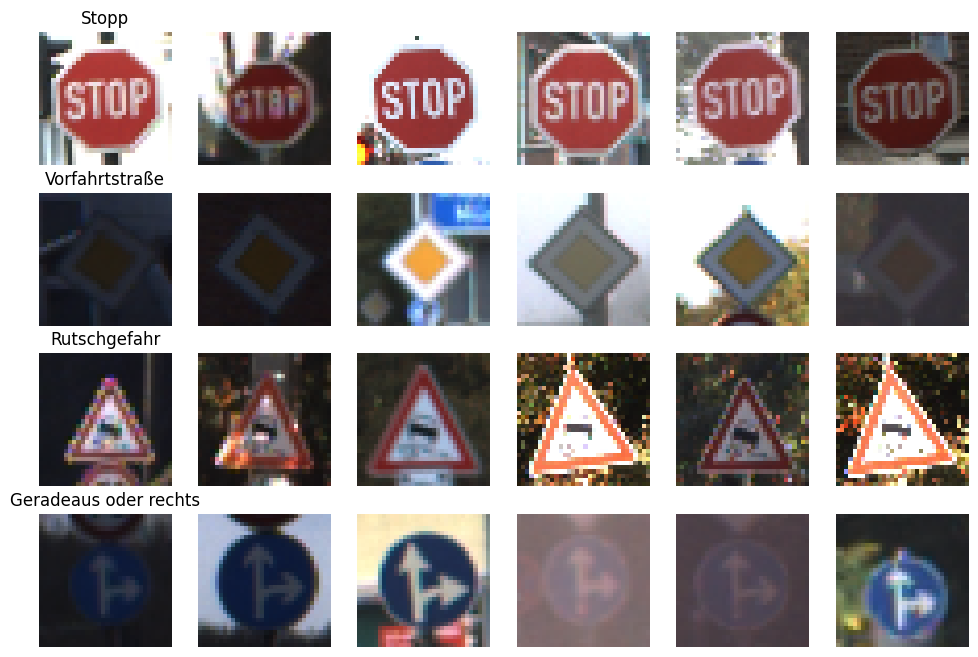

In [3]:
num_images = 6
classes_to_display = [14, 12, 23, 36]
fig, axs = plt.subplots(len(classes_to_display), num_images, figsize=(num_images * 2, len(classes_to_display) * 2))
print(f'Displaying {num_images} random images from each of the following categories: {", ".join([classes[class_num] for class_num in classes_to_display])}')

for i, class_num in enumerate(classes_to_display):
    class_images = [entry[0] for entry in data if entry[1] == class_num]
    
    if len(class_images) >= num_images:
        selected_images = random.sample(class_images, num_images)
    else:
        selected_images = class_images
    
    for j, image in enumerate(selected_images):
        axs[i, j].imshow(image, cmap='gray')
        axs[i, j].axis('off')
        if j == 0:
            axs[i, j].set_title(classes_german[class_num])

for ax in axs.flat:
    ax.axis('off')

# plt.savefig('media/Datenset_Auszug.png')
plt.show()

In [32]:
split_train_val = 0.8
split_index = int(len(data) * split_train_val)
np.random.shuffle(data)
train_data, val_data = data[:split_index], data[split_index:]
train_images, train_labels = np.array([entry[0] for entry in train_data]), np.array([entry[1] for entry in train_data])
val_images, val_labels = np.array([entry[0] for entry in val_data]), np.array([entry[1] for entry in val_data])

### MLP Training

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Input(shape=(img_size, img_size, 3)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(len(classes), activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(
            train_images,
            train_labels,
            batch_size=128,
            epochs=75,
            validation_data=(val_images, val_labels))


### CNN Training
Yesss! 90% val accuracy (still slight overfitting)
Idk if my network is too complex, it's inspired by a model for 43 different traffic signs, I reduced the layer sizes and increased regularization & dropout. BatchNormalization made the learning curve look weird.

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, AveragePooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam

# 32 (3, 3) 512 0.1 0.3 256 -> 0.981
# 32 (3, 3) 512 0.25 0.2 256 -> 0.980
# 64 (3, 3) 128 0.25 0.1 128 -> 0.981
# 32 (3, 3) 512 0.3 0.1 256 -> 0.979
# 32 (3, 3) 256 0.2 0.2 256 -> 0.979
# 32 (3, 3) 512 0 0.5 64 -> 0.978
# 32 (3, 3) 512 0.2 0.4 256 -> 0.979
# 32 (3, 3) 512 0.35 0.2 256 -> 0.978
# 64 (3, 3) 256 0.1 0.1 256 -> 0.978
# 64 (3, 3) 256 0.1 0.2 128 -> 0.979
# 64 (3, 3) 256 0.25 0.3 256 -> 0.979
# best: 32 (3, 3) 512 0.25 0.2 256

model = Sequential()
model.add(Input(shape=(img_size, img_size, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(classes), activation='softmax'))
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_images, 
    train_labels, 
    epochs=20,
    batch_size=256,
    validation_data=(val_images, val_labels))

Epoch 1/20


84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.1358 - loss: 76.8731 - val_accuracy: 0.6239 - val_loss: 1.4843
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6233 - loss: 1.4152 - val_accuracy: 0.8791 - val_loss: 0.5343
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8278 - loss: 0.6491 - val_accuracy: 0.9187 - val_loss: 0.3584
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8897 - loss: 0.4108 - val_accuracy: 0.9407 - val_loss: 0.2511
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9219 - loss: 0.2905 - val_accuracy: 0.9407 - val_loss: 0.2542
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9313 - loss: 0.2523 - val_accuracy: 0.9604 - val_loss: 0.1683
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9434 - loss: 0.2130 - val_accuracy: 0.9649 - val_loss: 0.1682
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9595 - loss: 0.1499 - val_accuracy: 0.9685 - val_loss: 0.1565
E

### Model Loading
Skip the training process above and instantly load a keras model from disk

In [35]:
from tensorflow.keras.saving import load_model
model = load_model('models/cnn_gtsrb_98_val_acc.keras')

### Model Evaluation

In [36]:
loss, accuracy = model.evaluate(val_images, val_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9966 - loss: 0.0387
Accuracy: 99.62%


### Training Visualization

Text(0, 0.5, 'Genauigkeit')

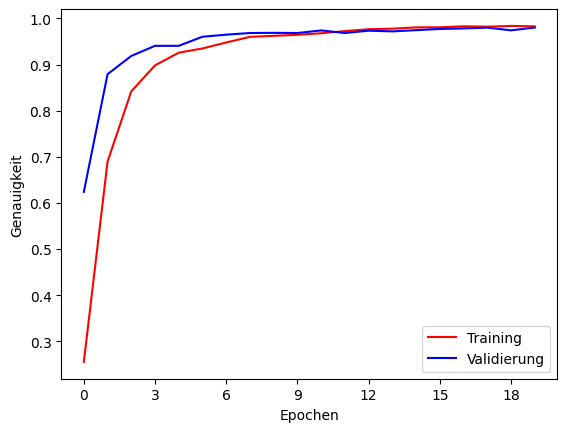

In [37]:
plt.plot(history.history['accuracy'], color='red', label='Training')
plt.plot(history.history['val_accuracy'], color='blue', label='Validierung')
plt.legend()
plt.xlabel('Epochen')
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
plt.ylabel('Genauigkeit')
# plt.savefig('media/CNN_Training_Diagramm.png')
# model.save('models/cnn_gtsrb_98_val_acc.keras')

Create confusion matrix

103/666 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step

666/666 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step


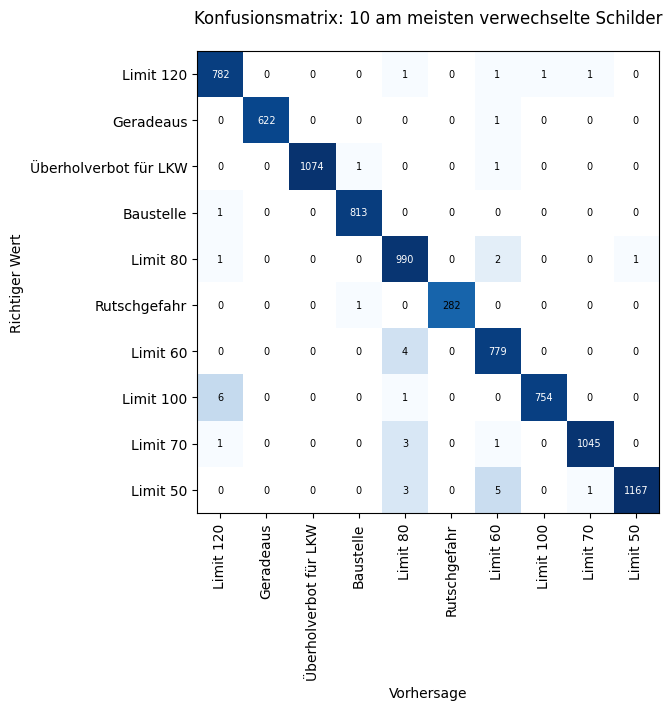

In [ ]:
predictions = model.predict(train_images)
predicted_labels = np.argmax(predictions, axis=1)
conf_matrix = np.zeros((len(classes), len(classes)), dtype=int)

for true, prediction in zip(train_labels, predicted_labels):
    conf_matrix[true, prediction] += 1

missclassifications = np.sum(conf_matrix, axis=1) - np.diag(conf_matrix)
worst_classes = np.argsort(missclassifications)[-10:]

sub_matrix = conf_matrix[np.ix_(worst_classes, worst_classes)]

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(sub_matrix, cmap='Blues', norm=matplotlib.colors.LogNorm())
# cbar = plt.colorbar(cax, ticks=[1, 10, 100])
# cbar.ax.set_yticklabels(['0', '10', '100'])

ax.set_xticks(range(len(worst_classes)))
ax.set_yticks(range(len(worst_classes)))
ax.set_xticklabels([classes_german[class_num] for class_num in worst_classes])
ax.set_yticklabels([classes_german[class_num] for class_num in worst_classes])
ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()
for x, row in enumerate(sub_matrix):
    for y, val in enumerate(row):
        ax.text(y, x, f'{val}', ha='center', va='center', color='black' if val < np.max(sub_matrix) / 2 else 'white', fontsize=7)

plt.xticks(rotation='vertical')
plt.xlabel('Vorhersage')
plt.ylabel('Richtiger Wert')
plt.title('Konfusionsmatrix: 10 am meisten verwechselte Schilder', pad=20)
# plt.savefig('media/CNN_Konfusionsmatrix.png', bbox_inches='tight')
plt.show()


### Model Visualization
Displays each layer, filter and output with matplotlib

In [ ]:
from IPython.display import clear_output
import os
import shutil

def reshape_to_aspect(arr, aspect_ratio):
    """
    Reshapes a 1D numpy array into a 2D grid that best matches the desired aspect ratio.
    Adds padding (zeros) if necessary to fill the grid.
    
    Parameters:
    arr (numpy.ndarray): 1D input array.
    aspect_ratio (tuple): Desired aspect ratio as (width, height).
    
    Returns:
    numpy.ndarray: 2D reshaped array with padding if necessary.
    """
    if arr.size == 0:
        return np.zeros((0, 0))
    
    w, h = aspect_ratio
    target_ratio = w / h
    N = arr.size
    
    # Calculate ideal number of rows based on target ratio
    rows_ideal = np.sqrt(N / target_ratio)
    
    # Determine the range of rows to check around the ideal value
    min_row = max(1, int(np.floor(rows_ideal)) - 3)
    max_row = int(np.ceil(rows_ideal)) + 3
    
    best_diff = float('inf')
    best_pad = float('inf')
    best_shape = (1, N)  # Default shape, will be updated
    
    for row in range(min_row, max_row + 1):
        if row == 0:
            continue
        cols = (N + row - 1) // row  # Ceiling division
        actual_ratio = cols / row
        ratio_diff = abs(actual_ratio - target_ratio)
        padding = row * cols - N
        
        # Update best candidate if current is better
        if (ratio_diff < best_diff) or (ratio_diff == best_diff and padding < best_pad):
            best_diff = ratio_diff
            best_pad = padding
            best_shape = (row, cols)
    
    # Pad the array with zeros to fit the desired shape
    padded = np.pad(arr, (0, best_shape[0] * best_shape[1] - N), mode='constant')
    
    return padded.reshape(best_shape)

def save_model_layer_images(test_image, save_path='media/model'):
    print(f'Saving model layers as images in {save_path}...')

    if os.path.exists(save_path):
        shutil.rmtree(save_path)
    
    os.mkdir(save_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(test_image[0])
    plt.axis('off')
    plt.savefig(os.path.join(save_path, 'input_image.png'), bbox_inches='tight')
    plt.clf()

    for i, layer in enumerate(model.layers):
        layer_visible = False

        if isinstance(layer, Conv2D):
            layer_visible = True
            output = Sequential(layers=model.layers[:i+1]).predict(test_image, verbose=0)
            filters = layer.get_weights()[0]
            n_filters = filters.shape[3]
            
            height = 20
            fig, axs = plt.subplots(n_filters, 2, figsize=(height / n_filters * 2 + 1, height))
            
            # axs[0, 0].set_title(f'Gewichte')
            for j in range(n_filters):
                filter_viz = np.mean(filters[:, :, :, j-1], axis=2)
                axs[j, 0].imshow(filter_viz, cmap='gray')
                axs[j, 0].axis('off')
            
            # axs[0, 1].set_title(f'Output')
            for j in range(n_filters):
                axs[j, 1].imshow(output[0, :, :, j], cmap='gray')
                axs[j, 1].axis('off')
            
            plt.subplots_adjust(wspace=0, hspace=0)
            plt.tight_layout(h_pad=height / n_filters * 0.5)
            
        elif isinstance(layer, (MaxPooling2D, AveragePooling2D)):
            layer_visible = True
            output = Sequential(layers=model.layers[:i+1]).predict(test_image, verbose=0)
            n_outputs = output.shape[-1]
            
            height = 20
            fig, axs = plt.subplots(n_outputs, 1, figsize=(height / n_outputs * 2, height))
            
            for j in range(n_outputs):
                axs[j].imshow(output[0, :, :, j], cmap='gray' if output.shape[-1] != 3 else ['Reds', 'Greens', 'Blues'][j])
                axs[j].axis('off')
            
            plt.tight_layout(h_pad=height / n_outputs * 0.5)
        
        elif i == len(model.layers) - 1:
            layer_visible = True
            output = Sequential(layers=model.layers[:i+1]).predict(test_image, verbose=0)
            fig, ax = plt.subplots(1, 1, figsize=(2, 8))
            ax.barh(np.arange(len(output[0])), output[0])
            ax.set_yticks(np.arange(len(output[0])))
            ax.set_yticklabels([categories[i].replace('Speed ', '') for i in range(len(output[0]))], rotation=45, ha='right')
            plt.tight_layout()
            
        elif isinstance(layer, Dense):
            layer_visible = True
            output = Sequential(layers=model.layers[:i+1]).predict(test_image, verbose=0)
            image = reshape_to_aspect(output[0], (1, len(output[0]) // 2))
            fig, ax = plt.subplots(figsize=(2, 20))
            plt.axis('off')
            plt.imshow(image, cmap='gray')
        
        if layer_visible:
            plt.savefig(os.path.join(save_path, f'layer_{i}'), bbox_inches='tight')
            plt.clf()
    
    print(f'Saved model layers as images in {save_path}!')

def plot_model_from_saved_images(save_path='media/model'):
    visible_layers = [(i, layer) for i, layer in enumerate(model.layers) 
                  if isinstance(layer, (MaxPooling2D, AveragePooling2D, Conv2D, Dense))]

    fig, ax = plt.subplots(1, len(visible_layers) + 1, figsize=(20, 15))
    ax[0].imshow(plt.imread(os.path.join(save_path, 'input_image.png')))
    ax[0].axis('off')

    for j, (i, layer) in enumerate(visible_layers):
        ax[j + 1].imshow(plt.imread(os.path.join(save_path, f'layer_{i}.png')))
        ax[j + 1].axis('off')

        if isinstance(layer, Conv2D):
           pass
            
        elif isinstance(layer, (MaxPooling2D, AveragePooling2D)):
            pass
        
        elif i == len(model.layers) - 1:
            pass
            
        elif isinstance(layer, Dense):
            pass
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout(pad=0)
    plt.show()
            
    
def plot_model(test_image):
    clear_output(wait=True)
    print(model.summary())
    save_model_layer_images(test_image)
    plot_model_from_saved_images()
    


# find images from validation set that are misclassified
# misclassified = []
# for i, (image, label) in enumerate(zip(validate_images, validate_labels)):
#     prediction = model.predict(image[np.newaxis, ...])
#     predicted_label = np.argmax(prediction)
#     if predicted_label != label or True:
#         misclassified.append((image, label, predicted_label))
#         visualize_model(np.array([image]))
#         break
#         input('Weiter mit Enter')

stop_signs = [entry for entry in validate_data if entry.labels[0].category == 14]
test_image = np.array([stop_signs[8].image])

plot_model(test_image)
    

### Example predictions
Show the model's guesses on different images from the dataset

  1/666 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step

666/666 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step   
Skipped: 1392 correctly classified images


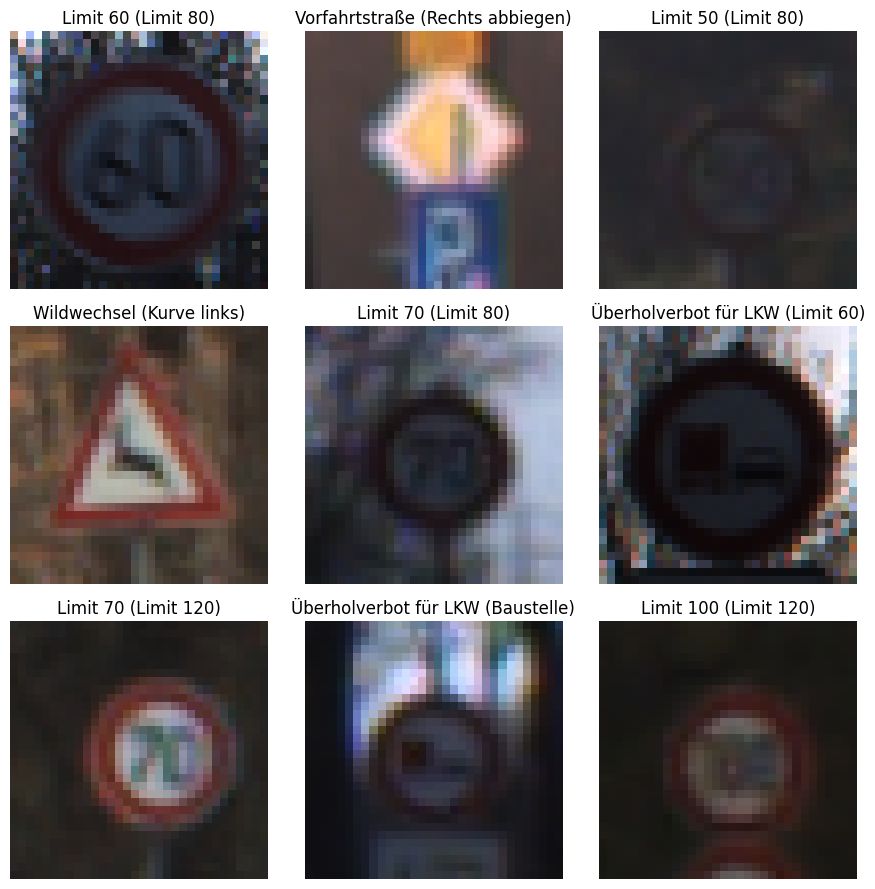

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

only_misclassified = True
skipped = 0
n, m = 3, 3
figsize = (m * 3, n * 3)

misclassified = []
predictions = model.predict(train_images)
predicted_labels = np.argmax(predictions, axis=1)

for true, prediction, image in zip(train_labels, predicted_labels, train_images):
    if true == prediction and only_misclassified:
        skipped += 1
        continue

    misclassified.append((image, true, prediction))

    if len(misclassified) == n * m:
        print(f'Skipped: {skipped} correctly classified images')
        skipped = 0
        
        fig, axes = plt.subplots(n, m, figsize=figsize)
        axes = axes.ravel()
        
        for i, (img, true_label, pred_label) in enumerate(misclassified):
            axes[i].imshow(img, cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f'{classes_german[true_label]} ({classes_german[pred_label]})')
        
        plt.tight_layout()
        # plt.savefig('media/temp.png')
        plt.show()
        user_input = input('Press enter and type "exit" to exit...')
        if user_input == 'exit':
            # os.rename('media/temp.png', 'media/CNN_Falsche_Vorhersagen.png')
            break
        
        clear_output(wait=True)
        
        misclassified = []



___
## Image Experiments

### Convolution

In [ ]:
def apply_filter(image: np.array, filter: np.array, stride: int = 1)->np.array:
    image_copy = deepcopy(image)
    filter_size = filter.shape[0]
    image_size = image.shape[0]
    for i in range(0, image_size - filter_size + 1, stride):
        for j in range(0, image_size - filter_size + 1, stride):
            image[i:i + filter_size, j:j + filter_size] = (image_copy[i:i + filter_size, j:j + filter_size] * filter).sum()
    
    return image


stop_signs = [entry for entry in validate_data if entry.labels[0].category == 14]
grayscale_img = np.array(stop_signs[8].image).sum(axis=2) / 3
vertical_edge_filter = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
horizontal_edge_filter = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
laplace_edge_filter = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

plt.axis('off')
plt.imshow(grayscale_img, cmap='gray')
# plt.imsave('media/Stoppschild_laplace.png', grayscale_img, cmap='gray')

horizontal = apply_filter(deepcopy(grayscale_img),  horizontal_edge_filter, stride=1)
laplace = apply_filter(deepcopy(grayscale_img), laplace_edge_filter, stride=1)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(horizontal, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Horizontale Kanten')

axs[1].imshow(laplace, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Laplace-Filter')

### Show how an image is made out of numbers

In [ ]:
stop_signs = [entry for entry in validate_data if entry.labels[0].category == 14]

size = 14
grayscale_img = np.array(stop_signs[8].image).sum(axis=2) / 3
scaled_img = np.array(Image.fromarray(grayscale_img).resize((size, size)))
fig, axs = plt.subplots(1, 3, figsize=(16, 8))
axs[0].imshow(grayscale_img, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Original (Schwarz-Weiß)')

axs[1].imshow(scaled_img, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Skaliert auf 14x14 Pixel')

axs[2].imshow(scaled_img, cmap='gray')
axs[2].axis('off')
axs[2].set_title('Helligkeitswerte')

for i in range(size):
    for j in range(size):
        axs[2].text(j, i, f'{scaled_img[i, j]:.2f}', ha='center', va='center', color='black' if scaled_img[i, j] > 0.5 else 'white', fontsize=7)

plt.show()
